In [1]:
#importing packages
import pandas as pd
import numpy as np

In [2]:
# Importing the dataset
X = pd.read_csv('HealtyNormalized.csv')

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 0)

In [4]:
train = X_train
train

,vsH,vbH
1545950,0.000327,0.000465
842508,0.001032,0.000628
1689121,0.001009,-0.001388
1722866,0.000992,0.000238
1756169,0.000009,-0.000250
...,...,...
152315,0.000009,0.000726
963395,0.001020,0.000888
117952,0.000009,-0.000152
1484405,0.000008,-0.000348


In [5]:
test = X_test
test

,vsH,vbH
1563010,0.000009,0.000010
1144975,0.000725,0.000660
356424,0.000995,0.000173
247169,0.000009,-0.000022
1659074,0.001001,0.000010
...,...,...
1508691,0.000009,0.000823
167734,0.000009,0.000498
1374343,0.001003,-0.001258
384688,0.001022,0.000108


In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train = pd.DataFrame(scaler.fit_transform(train))
train.sample(frac=1)

test = pd.DataFrame(scaler.transform(test))

In [7]:
train.shape

(1599954, 2)

In [15]:
test.shape

(399989, 2)

In [16]:
train = train.values.reshape(-1, 1, 2)

In [17]:
test  = test.values.reshape(-1, 1, 2)

In [18]:
#pip install keras
train.shape

(1599954, 1, 2)

In [19]:
test.shape

(399989, 1, 2)

In [20]:
from keras.layers import Input, Dropout, Dense, LSTM, RepeatVector, TimeDistributed
from keras.models import Model, Sequential, load_model
from keras import regularizers

In [21]:
# Input layer:
model=Sequential([
    LSTM(32, activation='relu', input_shape=(train.shape[1],train.shape[2])),
    Dropout(0.2),
    RepeatVector(train.shape[1]),
    LSTM(32, activation='relu', return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(train.shape[2]))
])

model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4480      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 32)             8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 2)              66        
Total params: 12,866
Trainable params: 12,866
Non-trainable params: 0
____________________________________________________

In [22]:
# Train model for 100 epochs, batch size of 1000: 
NUM_EPOCHS=10
BATCH_SIZE=1000

history=model.fit(train,train, 
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  shuffle=True)

Epoch 1/10
1440/1440 [==============================] - 7s 5ms/step - loss: 0.0362 - accuracy: 0.9374 - val_loss: 0.0018 - val_accuracy: 0.9962
Epoch 2/10
1440/1440 [==============================] - 6s 4ms/step - loss: 0.0067 - accuracy: 0.9952 - val_loss: 0.0011 - val_accuracy: 0.9966
Epoch 3/10
1440/1440 [==============================] - 7s 5ms/step - loss: 0.0046 - accuracy: 0.9946 - val_loss: 5.8341e-04 - val_accuracy: 0.9976
Epoch 4/10
1440/1440 [==============================] - 7s 5ms/step - loss: 0.0039 - accuracy: 0.9939 - val_loss: 5.3865e-04 - val_accuracy: 0.9985
Epoch 5/10
1440/1440 [==============================] - 7s 5ms/step - loss: 0.0035 - accuracy: 0.9949 - val_loss: 5.0573e-04 - val_accuracy: 0.9990
Epoch 6/10
1440/1440 [==============================] - 6s 4ms/step - loss: 0.0034 - accuracy: 0.9949 - val_loss: 4.6773e-04 - val_accuracy: 0.9991
Epoch 7/10
1440/1440 [==============================] - 6s 4ms/step - loss: 0.0034 - accuracy: 0.9951 - val_loss: 3.7543

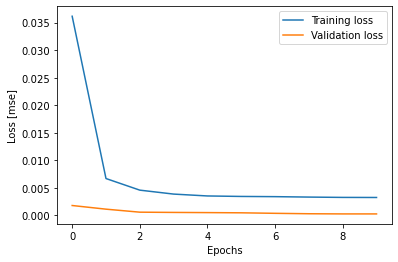

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss [mse]')
plt.show()

In [24]:
pred_train = model.predict(train)

In [25]:
pred_train = pred_train.reshape(pred_train.shape[0],pred_train.shape[2])
train = train.reshape(train.shape[0],train.shape[2])

C:\Users\bahma\.conda\envs\svm\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


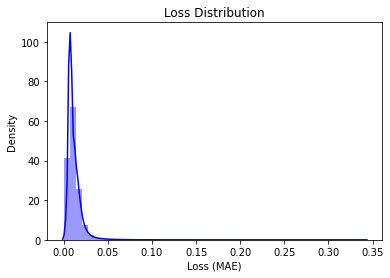

In [26]:
import seaborn as sns

scored = np.mean(np.abs(pred_train-train), axis = 1)
plt.figure()
g = sns.distplot(scored, bins = 50, kde= True, color = 'blue');
plt.title('Loss Distribution')
plt.xlabel('Loss (MAE)')
plt.show()

In [27]:
TH = 0.056
pred_train = pd.DataFrame(pred_train)
scored_train = pd.DataFrame()
scored_train['Loss_mae'] = np.mean(np.abs(pred_train-train), axis = 1)
scored_train['Threshold'] = TH
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']

In [28]:
scored_train['Loss_mae'].mean()

0.01128942583376743

Text(0, 0.5, 'Loss (MAE)')

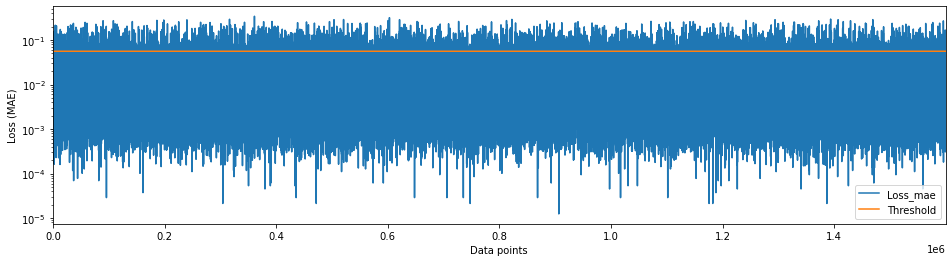

In [29]:
scored_train.plot(logy=True,  figsize = (16,4), xlim =[0,len(scored_train)])
plt.xlabel('Data points')
plt.ylabel('Loss (MAE)')

In [30]:
scored_train

,Loss_mae,Threshold,Anomaly
0,0.015681,0.056,False
1,0.014296,0.056,False
2,0.027049,0.056,False
3,0.001878,0.056,False
4,0.006786,0.056,False
...,...,...,...
1599949,0.011593,0.056,False
1599950,0.014025,0.056,False
1599951,0.005790,0.056,False
1599952,0.007840,0.056,False


In [31]:
anomalies = scored_train[scored_train['Anomaly'] == True]
print(anomalies)
print(anomalies.shape)

         Loss_mae  Threshold  Anomaly
256      0.061229      0.056     True
299      0.061405      0.056     True
898      0.154479      0.056     True
1075     0.067330      0.056     True
1195     0.059240      0.056     True
...           ...        ...      ...
1599089  0.063824      0.056     True
1599193  0.070670      0.056     True
1599469  0.061490      0.056     True
1599783  0.071088      0.056     True
1599787  0.077570      0.056     True

[6573 rows x 3 columns]
(6573, 3)


C:\Users\bahma\.conda\envs\svm\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


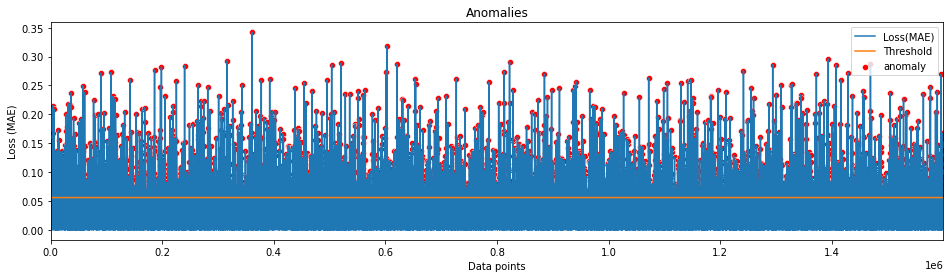

In [33]:
f, (ax1) = plt.subplots(figsize=(16, 4))
ax1.plot(scored_train.index, scored_train.Loss_mae, label='Loss(MAE)');
ax1.plot(scored_train.index, scored_train.Threshold, label='Threshold')
g = sns.scatterplot(x=anomalies.index , y=anomalies.Loss_mae, label='anomaly', color='red')
g.set(xlim = (0, len(scored_train.index)))
plt.title('Anomalies')
plt.xlabel('Data points')
plt.ylabel('Loss (MAE)')
plt.legend();

In [34]:
pred_test = model.predict(test)

In [35]:
score = model.evaluate(test,test)
score

12500/12500 [==============================] - 11s 913us/step - loss: 2.6546e-04 - accuracy: 0.9992


[0.00026545970467850566, 0.9991524815559387]

In [36]:
pred_test = pred_test.reshape(pred_test.shape[0],pred_test.shape[2])
test = test.reshape(test.shape[0],test.shape[2])

C:\Users\bahma\.conda\envs\svm\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


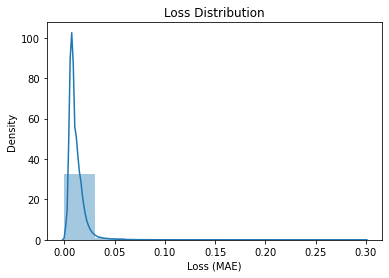

In [37]:
import seaborn as sns

scored_test = np.mean(np.abs(pred_test-test), axis = 1)
plt.figure()
g = sns.distplot(scored_test, bins = 10, kde= True);
plt.title('Loss Distribution')
plt.xlabel('Loss (MAE)')
plt.show()

In [38]:
scored_test = pd.DataFrame()
scored_test['Loss_mae'] = np.mean(np.abs(pred_test-test), axis = 1)
scored_test['Threshold'] = TH
scored_test['Anomaly'] = scored_test['Loss_mae'] > scored_test['Threshold']

scored_test

,Loss_mae,Threshold,Anomaly
0,0.004814,0.056,False
1,0.009987,0.056,False
2,0.002491,0.056,False
3,0.004299,0.056,False
4,0.004760,0.056,False
...,...,...,...
399984,0.012385,0.056,False
399985,0.009400,0.056,False
399986,0.020096,0.056,False
399987,0.009280,0.056,False


In [39]:
scored_test['Loss_mae'].mean()

0.011280956023553532

Text(0, 0.5, 'Loss (MAE)')

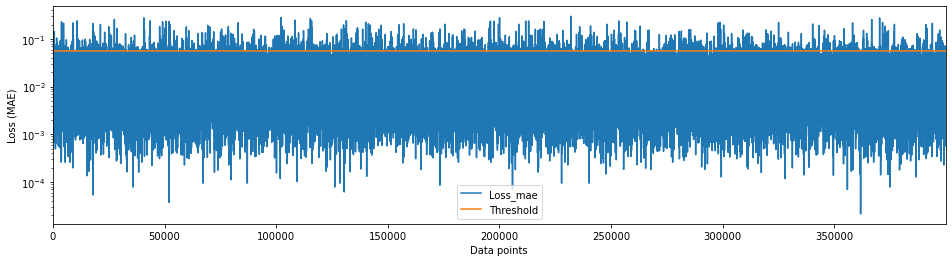

In [40]:
scored_test.plot(logy=True,  figsize = (16,4), xlim =[0,len(scored_test)])
plt.xlabel('Data points')
plt.ylabel('Loss (MAE)')

In [42]:
IR_anomalies = scored_test[scored_test['Anomaly'] == True]
print(IR_anomalies)
print(IR_anomalies.shape)

        Loss_mae  Threshold  Anomaly
52      0.143995      0.056     True
70      0.090661      0.056     True
603     0.106029      0.056     True
626     0.143852      0.056     True
1108    0.067274      0.056     True
...          ...        ...      ...
398773  0.082381      0.056     True
398971  0.058609      0.056     True
399635  0.058992      0.056     True
399674  0.071516      0.056     True
399804  0.058202      0.056     True

[1630 rows x 3 columns]
(1630, 3)


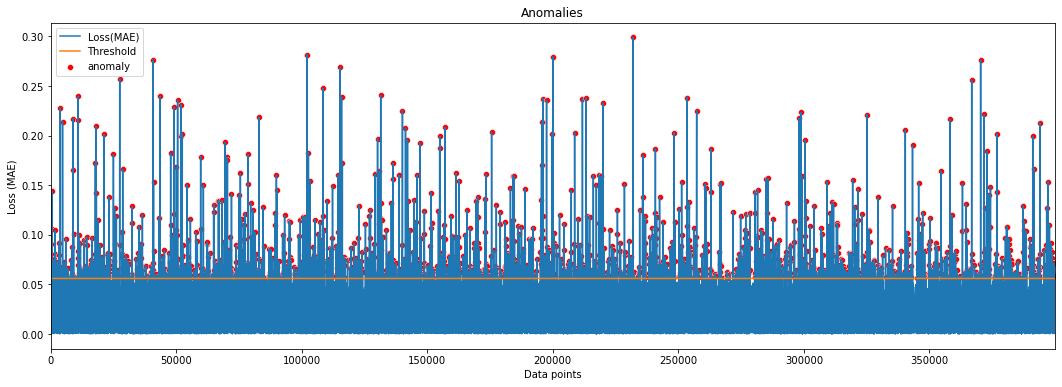

In [43]:
f, (ax2) = plt.subplots(figsize=(18, 6))
ax2.plot(scored_test.index, scored_test.Loss_mae, label='Loss(MAE)');
ax2.plot(scored_test.index, scored_test.Threshold, label='Threshold')
g = sns.scatterplot(x=IR_anomalies.index , y=IR_anomalies.Loss_mae, label='anomaly', color='red')
g.set(xlim = (0, len(scored_test.index)))
plt.title('Anomalies')
plt.xlabel('Data points')
plt.ylabel('Loss (MAE)')
plt.legend();

In [44]:
print(score[1])

0.9991524815559387


In [45]:
print("Accuracy: {:.2f}%".format(score[1]*100))

Accuracy: 99.92%


In [46]:
print("Anomalies: {}".format(IR_anomalies['Anomaly'].count()))

Anomalies: 1630


In [47]:
# Seperating Normal and Faulty dataset
x = scored_test['Anomaly'].count() / 2

In [48]:
normal_test = scored_test[scored_test.index < x]
normal_test

,Loss_mae,Threshold,Anomaly
0,0.004814,0.056,False
1,0.009987,0.056,False
2,0.002491,0.056,False
3,0.004299,0.056,False
4,0.004760,0.056,False
...,...,...,...
199990,0.005201,0.056,False
199991,0.010891,0.056,False
199992,0.005096,0.056,False
199993,0.006824,0.056,False


In [49]:
IR_test = scored_test[scored_test.index >= x]
IR_test

,Loss_mae,Threshold,Anomaly
199995,0.006929,0.056,False
199996,0.007224,0.056,False
199997,0.008066,0.056,False
199998,0.007148,0.056,False
199999,0.006323,0.056,False
...,...,...,...
399984,0.012385,0.056,False
399985,0.009400,0.056,False
399986,0.020096,0.056,False
399987,0.009280,0.056,False


In [50]:
TP = normal_test[normal_test['Anomaly'] == False]
TP = TP['Anomaly'].count()
print("True Positives: {}".format(TP))

FP = normal_test[normal_test['Anomaly'] == True]
FP = FP['Anomaly'].count()
print("False Positives: {}".format(FP))

TN = IR_test[IR_test['Anomaly'] == True]
TN = TN['Anomaly'].count()
print("True Negatives: {}".format(TN))

FN = IR_test[IR_test['Anomaly'] == False]
FN = FN['Anomaly'].count()
print("False Negatives: {}".format(FN))

True Positives: 199152
False Positives: 843
True Negatives: 787
False Negatives: 199207


In [51]:
Precision = TP / (TP + FP)
print("Precision: {:.2f}%".format(Precision*100))

Recall = TP / (TP + FN)
print("Recall: {:.3f}%".format(Recall*100))

F1Score = (2*Precision*Recall)/(Precision+Recall)
print("F1 Score: {:.2f}%".format(F1Score*100))

Accuracy = ( TP + TN ) / ( TP + TN + FN + FP )
print("Accuracy: {:.2f}%".format(Accuracy*100))

Precision: 99.58%
Recall: 49.993%
F1 Score: 66.57%
Accuracy: 49.99%
